In [ ]:
import pandas as pd
intrusion_df = pd.read_csv('simulation_dataframe.csv')

In [ ]:
intrusion_df.shape

(682365, 67)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:

## remove ambivalent runs
base = '/home/snorre/Dropbox/Forskning/bigdata/data_inspections/'
meta_path = base+'simulation_results/metrics/'
meta_path2 = base+'simulation_results/distributions/'
from os import listdir
from collections import Counter
import pandas as pd
meta_files = [meta_path+i for i in listdir(meta_path)]
result_path = '/mnt/b0c8e396-e5ba-4614-be6f-146c4c861ab3/data/topic_model_simulation/models/'
model_runs = set(['_'.join(i.split('_')[0:3]) for i in listdir(result_path)])
model_runs = sorted(model_runs,key=lambda x: int(x.split('_')[-1]))

dfs = []
for num,filename in enumerate(meta_files):
    df = pd.read_csv(filename)
    df['simulation_id'] = num
    dfs.append(df)
df = pd.concat(dfs)
df = df.sort_values('modelid')
del dfs
c = Counter([i.split('_')[-1] for i in model_runs])
model_errors = set(df.modelid.value_counts().index[df.modelid.value_counts()>1])
model_errors.update(set([int(i) for i,count in c.most_common(len(c)) if count>1]))
df = df[~df.modelid.isin(model_errors)]
df = df[df.simulation_id.isin(set(df.simulation_id.value_counts()[df.simulation_id.value_counts()==29].index))]
df.shape

(8091, 13)

In [ ]:
intrusion_df = intrusion_df[intrusion_df.model_id.isin(set(df.modelid))]
intrusion_df.shape

(647280, 67)

In [ ]:
  intrusion_df = intrusion_df.merge(df,how='left',left_on = 'model_id',right_on = 'modelid')

In [ ]:
#intrusion_df.n_topics.value_counts().sort_index().plot()

In [ ]:
#intrusion_df

In [ ]:
import numpy as np

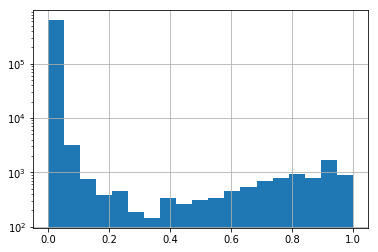

In [ ]:
intrusion_df[intrusion_df.d_noisy_share>0].d_noisy_share.hist(bins=np.linspace(0,1,20))
plt.yscale('log')

In [ ]:
w_col = 'topoverlap_%d_noise'
w_over = 'topoverlap_%d_overlap'
doc_col = 'top_doc_overlap_%d'
dk_df = intrusion_df[(intrusion_df[w_col%20]==0) &(intrusion_df[doc_col%5]==0)]
problem_df = dk_df[dk_df.d_noisy_share>0]
print(('%d topics are believed to be danish looking only at the top 20 words, and top 10 docs. '
+ '%d of these contain English documents, i.e. %r percent')%(len(dk_df),len(problem_df),round(len(problem_df)/len(dk_df),3)))

629497 topics are believed to be danish looking only at the top 20 words, and top 10 docs. 599337 of these contain English documents, i.e. 0.952 percent


In [ ]:
k = 20

In [ ]:
#plt.scatter(model_df.noise,model_df.noise_fraction)

In [ ]:
w_col_real = 'topoverlap_%d_real'

In [ ]:
def make_bin(val,scale=0.05):
    return val-val%scale
make_bin(1.75)

1.7000000000000002

14.925373134328357

In [ ]:
dom_factor = 0.5
k = 20
def get_unnoticed(groupdf,k=20,doc=True):
    if doc:
        
        return (groupdf[w_col_real%k]/k>=dom_factor)& (groupdf[w_col%k]==0) &(groupdf[doc_col%5]==0)
    else:
        return (groupdf[w_col_real%k]/k>=dom_factor)& (groupdf[w_col%k]==0)

intrusion_df['noise_noticed_no_doc'] = get_unnoticed(intrusion_df,k,doc=False)
intrusion_df['noise_noticed'] = get_unnoticed(intrusion_df,k)


In [ ]:
sns.heatmap(model_df.groupby(['noise','n_topics']).)

In [ ]:

intrusion_df['noise_bin'] = intrusion_df.d_noisy_share.apply(make_bin)

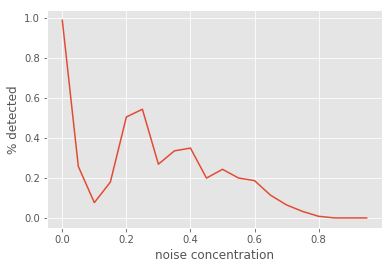

In [ ]:
intrusion_df.groupby('noise_bin').noise_noticed.mean().plot()
plt.ylabel('% detected')
plt.xlabel('noise concentration')
plt.savefig('output/noise_detection/detected_frac.png')

In figure *noise_detection_magnitude* we report the concentration of noise in all topics where the noise was unnoticed. We see that while many topics have only moderate levels of noise, it can still go unnoticed with up to 80 % of the topic. Here we might 

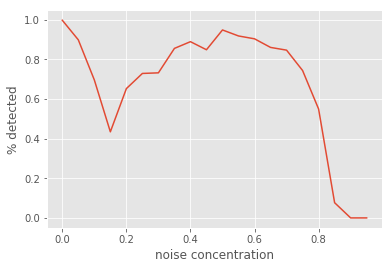

In [ ]:
intrusion_df.groupby('noise_bin').noise_noticed_no_doc.mean().plot()
plt.ylabel('% detected')
plt.xlabel('noise concentration')
plt.savefig('output/noise_detection/detected_frac_no_doc.png')


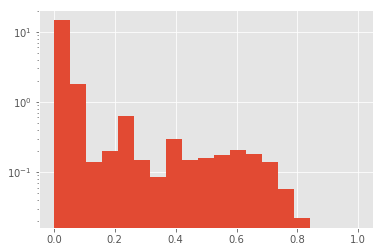

In [ ]:

plt.hist(intrusion_df[get_unnoticed(intrusion_df) & (intrusion_df.noise>0)].groupby('model_id').d_noisy_share.max(),bins=np.linspace(0,1,20),density=True)#.hist(bins=np.linspace(0,1,20),density=True)
plt.yscale('log')
#plt.savefig('output/noise_detection/distribution_noise.png')


In [ ]:
#def get_unnoticed(groupdf,k=20):
#    return (groupdf[w_col%k]==0) &(groupdf[doc_col%5]==0) #& (groupdf[w_col_real%k]>k/2)&
#model_df = pd.DataFrame(problem_df.groupby('model_id').topic2global_noise.max()).reset_index()
#model_df.columns = ['model_id','noise_fraction']
dom_factor = 0.5
k = 20
def get_unnoticed(groupdf,k=20,doc=True):
    if doc:
        
        return (groupdf[w_col_real%k]/k>dom_factor)& (groupdf[w_col%k]==0) &(groupdf[doc_col%5]==0)
    else:
        return (groupdf[w_col_real%k]/k>dom_factor)& (groupdf[w_col%k]==0)

model_df = pd.DataFrame(intrusion_df.groupby('model_id').d_noisy_share.max()).reset_index()
model_df.columns = ['model_id','noise_fraction']
model_df = model_df.merge(df,left_on='model_id',right_on='modelid')
temp = pd.DataFrame(intrusion_df.groupby('model_id')[w_col%k].max()).reset_index()
temp.columns = ['model_id','matches']
model_df = model_df.merge(temp)
model_df = model_df[model_df.noise>0]
temp = pd.DataFrame(intrusion_df.groupby('model_id').apply(lambda x: sum(get_unnoticed(x,k=k,doc=False))/len(x))).reset_index()
temp.columns = ['model_id','all_danish']
model_df = model_df.merge(temp)


In [ ]:
dom_factor = 0.5
k = 20
def get_unnoticed(groupdf,k=20,doc=True,dom=0.5):
    boolean = (groupdf[w_col%k]==0)
    if doc:
        boolean = boolean &(groupdf[doc_col%5]==0)
    if dom:
        bolean = boolean & (groupdf[w_col_real%k]/k>dom)
    return boolean

intrusion_df['noise_noticed_no_doc'] = get_unnoticed(intrusion_df,k,doc=False)
intrusion_df['noise_noticed_no_dom'] = get_unnoticed(intrusion_df,k,dom=False,doc=False)
intrusion_df['noise_noticed'] = get_unnoticed(intrusion_df,k)

In [ ]:
#def get_unnoticed(groupdf,k=20):
#    return (groupdf[w_col%k]==0) &(groupdf[doc_col%5]==0) #& (groupdf[w_col_real%k]>k/2)&
#model_df = pd.DataFrame(problem_df.groupby('model_id').topic2global_noise.max()).reset_index()
#model_df.columns = ['model_id','noise_fraction']

model_df = pd.DataFrame(intrusion_df.groupby('model_id').d_noisy_share.max()).reset_index()
model_df.columns = ['model_id','noise_fraction']
model_df = model_df.merge(df,left_on='model_id',right_on='modelid')
temp = pd.DataFrame(intrusion_df.groupby('model_id')[w_col%k].max()).reset_index()
temp.columns = ['model_id','matches']
model_df = model_df.merge(temp)
model_df = model_df[model_df.noise>0]


In [ ]:
temp = pd.DataFrame(intrusion_df.groupby('model_id').apply(lambda x: sum(get_unnoticed(x,k=k,doc=False))/len(x))).reset_index()
temp.columns = ['model_id','all_danish']
model_df = model_df.merge(temp)

temp = pd.DataFrame(intrusion_df.groupby('model_id').apply(lambda x: x[get_unnoticed(x,doc=False)].d_noisy_share.max())).reset_index()
temp.columns = ['model_id','noise_level']
model_df = model_df.merge(temp)

In [ ]:

temp = pd.DataFrame(intrusion_df.groupby('model_id').apply(lambda x: sum(x[~x.noise_noticed].topic2global_noise)+sum(x[~x.noise_noticed].topic2global_overlap))).reset_index()
temp.columns = ['model_id','noise_detected_frac']
model_df = model_df.merge(temp)


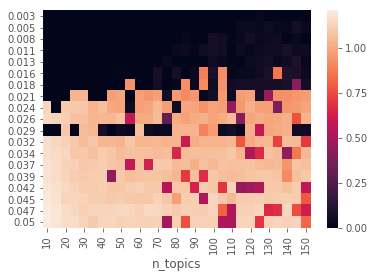

In [ ]:
noise_detect_df = model_df.groupby(['noise','n_topics']).apply(lambda x: x.noise_detected_frac.min()).unstack()
noise_detect_df.index = [round(i,3) for i in noise_detect_df.index]
sns.heatmap(noise_detect_df)


In [ ]:
#model_df.groupby(['noise','n_topics']).size()

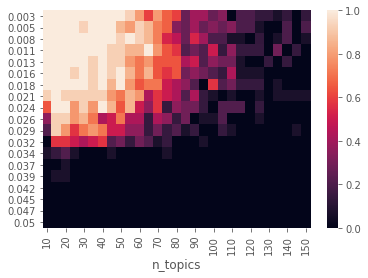

In [ ]:
noise_detect_df = model_df.groupby(['noise','n_topics']).apply(lambda x: sum(x.all_danish==1)/len(x)).unstack()
noise_detect_df.index = [round(i,3) for i in noise_detect_df.index]
sns.heatmap(noise_detect_df)


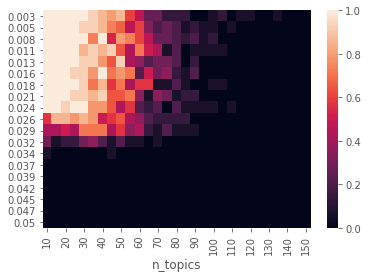

In [ ]:
noise_detect_df = model_df.groupby(['noise','n_topics']).apply(lambda x: sum(x.all_danish==1)/len(x)).unstack()
noise_detect_df.index = [round(i,3) for i in noise_detect_df.index]
sns.heatmap(noise_detect_df)


In [ ]:
#for i in overlap_idx:
#    print(Index[i])

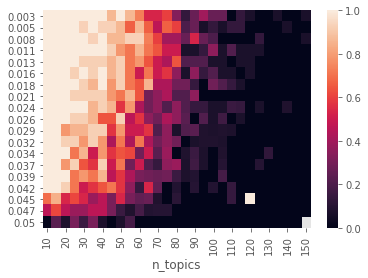

In [ ]:
noise_detect_df = model_df.groupby(['noise','n_topics']).apply(lambda x: sum(x.all_danish==1)/len(x)).unstack()
noise_detect_df.index = [round(i,3) for i in noise_detect_df.index]
sns.heatmap(noise_detect_df)


In [ ]:
! mkdir output/noise_detection

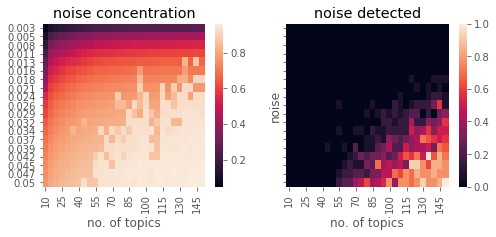

In [ ]:
noise_detect_df = model_df.groupby(['noise','n_topics']).apply(lambda x: sum(x.matches>0)/len(x)).unstack()
#noise_detect_df = model_df.groupby(['noise','n_topics']).apply(lambda x: sum(x.all_danish==1)/len(x)).unstack()
noise_detect_df.index = [round(i,3) for i in noise_detect_df.index]
fig,axes = plt.subplots(1,2,sharex=True,sharey = True)
ax = axes[1]
sns.heatmap(noise_detect_df,ax=ax)#.plot()
plt.ylabel('noise')
#ax.set_xlabel('no. of topics')
plt.xlabel('no. of topics')
ax.set_title('noise detected')
#
noise_detect_df = model_df.groupby(['noise','n_topics']).noise_fraction.median().unstack()
noise_detect_df.index = [round(i,3) for i in noise_detect_df.index]
ax = axes[0]
ax.set_title('noise concentration')

sns.heatmap(noise_detect_df,ax=ax)#.plot()
ax.set_xlabel('no. of topics')
fig.set_size_inches(8,3)

plt.savefig('output/noise_detection/k_noise_fraction_detected.png')


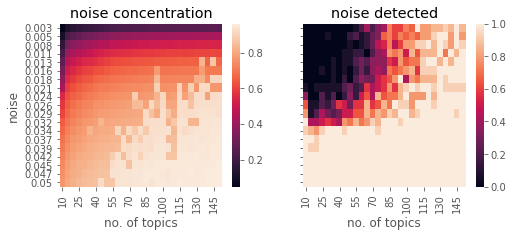

In [ ]:
#noise_detect_df = model_df.groupby(['noise','n_topics']).apply(lambda x: sum(x.matches>0)/len(x)).unstack()
noise_detect_df = model_df.groupby(['noise','n_topics']).apply(lambda x: 1-sum(x.all_danish==1)/len(x)).unstack()
noise_detect_df.index = [round(i,3) for i in noise_detect_df.index]
fig,axes = plt.subplots(1,2,sharex=True,sharey = True)
ax = axes[1]
sns.heatmap(noise_detect_df,ax=ax)#.plot()
#ax.set_xlabel('no. of topics')
plt.xlabel('no. of topics')
ax.set_title('noise detected')
#
noise_detect_df = model_df.groupby(['noise','n_topics']).noise_fraction.median().unstack()
noise_detect_df.index = [round(i,3) for i in noise_detect_df.index]
ax = axes[0]
ax.set_title('noise concentration')

sns.heatmap(noise_detect_df,ax=ax)#.plot()
ax.set_xlabel('no. of topics')
ax.set_ylabel('noise')
fig.set_size_inches(8,3)

plt.savefig('output/noise_detection/k_noise_fraction_detected+danish.png')


In [ ]:
temp = pd.DataFrame(intrusion_df.groupby('model_id').topic2global_noise.max()).reset_index()
temp.columns = ['model_id','noise_size']
model_df = model_df.merge(temp)

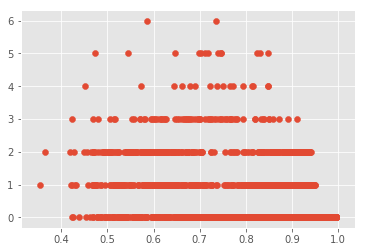

In [ ]:
plt.style.use('ggplot')
plt.scatter(model_df.noise_size,(model_df.matches))

In [ ]:
intrusion_df.topic2global_noise

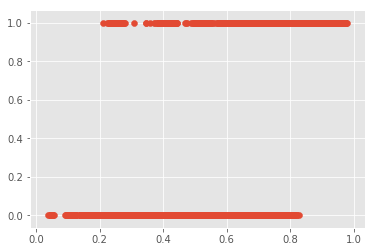

In [ ]:
plt.style.use('ggplot')
plt.scatter(model_df.noise_fraction,(1-model_df.all_danish)>0)

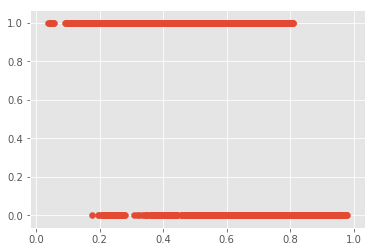

In [ ]:
plt.style.use('ggplot')
plt.scatter(model_df.noise_fraction,model_df.all_danish==1)

In [ ]:
## entropy of the categories, and entropy of noise.


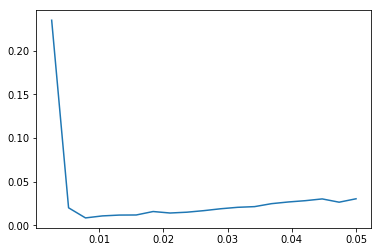

In [ ]:
plt.plot(model_df.groupby('noise').noise_fraction.median())

In [ ]:
from topsbm import TopSBM

In [ ]:
model = TopSBM(random_state=9)

In [ ]:
base = '/home/snorre/Dropbox/Forskning/bigdata/data_inspections/'
meta_path = base+'simulation_results/metrics/'
meta_path2 = base+'simulation_results/distributions/'
from os import listdir
result_path = '/mnt/b0c8e396-e5ba-4614-be6f-146c4c861ab3/data/topic_model_simulation/models/'
model_runs = set(['_'.join(i.split('_')[0:3]) for i in listdir(result_path)])
model_runs = sorted(model_runs,key=lambda x: int(x.split('_')[-1]))
print(len(model_runs))
#pol_df = pd.read_csv(base+'data/topic_modelling_dataset.csv').drop('bow',axis=1)
import pickle

pol_df,noise_df, Index = pickle.load(open(base+'topic_simulation_dependencies.pkl','rb'))
# Define where the noise begins.
noise_start_w = 30000
noise_start_d = len(pol_df)
list(enumerate(Index))[noise_start_w-2:noise_start_w+2],noise_start_w,noise_start_d
from collections import Counter
import re
import nltk


url_pattern = '(?:(?:https?:\/\/|www\.)\w+[\.\w]*\.\w+)|(?:\w+\.(?:com|dk))|(?:https?://|www\.)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
url_re = re.compile(url_pattern)
url_sub = ' __url__ '
digit_pattern = r"\d(?:[\.,\d]*\d+)|\d{2,}(?:[\.,\d]*\d+)?" # matching >1 figure digits
replace_regex = [(url_sub,url_re),(' __digit__ ',re.compile(digit_pattern))]


import numpy as np
def filter_words(words,stopwords):
    # filter non signs
    words = [word for word in words if isalphanum(word)]
    # filter stopwords
    words = [word for word in words if word not in stopwords]
    return words
def isalphanum(string):
    if not string.isalnum():
        # find word with - between
        pattern = r'[a-zAZøæåÆØÅ]+\-[a-zAZøæåÆØÅ]*|__[a-zAZøæåÆØÅ]+_*'
        search = re.findall(pattern,string)
        if len(search)>0:
            return True
        else:
            return False
    return True
def process_documents(text,stopwords):
    # replace known patterns.
    for sub_pattern,regex in replace_regex:
        text = regex.sub(sub_pattern,text)
    text = nltk.tokenize.word_tokenize(text)
    # lower
    text = [i.lower() for i in text]
    # remove stopwords
    text = filter_words(text,stopwords)
    return text
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english')) | set(['__digit__'])# english # 'hillary','trump'
stopwords = set(nltk.corpus.stopwords.words('danish'))#|set(open('danish_stopwords.txt','r').read().split('\n'))|set(['__digit__']) # danish

noise_docs = noise_df.message.apply(process_documents,**{'stopwords':stopWords}).values
real_docs = pol_df.message.apply(process_documents,**{'stopwords':stopwords}).values

def to_dense(corpus,vocab_size):
    X = np.zeros((len(corpus),vocab_size),dtype=np.int32)
    for num in range(len(corpus)):
        bow = corpus[num]
        for w,count in bow.items():
            try:
                X[num][w]=count
            except:
                pass
    return X
import scipy.sparse as sp
def to_sparse(corpus,vocab_size):
    X = sp.dok_matrix((len(corpus),vocab_size), dtype=np.int32)
    for num in range(len(corpus)):
        bow = corpus[num]
        for w,count in bow.items():            
            X[num,w]=count
    print(X.shape)
    X = X.tocsr()
    print(X.shape)
    return X

def to_index(text,d):
    return [d[i] for i in text if i in d]
def to_bow(texts,d,sparse = True):
    global vocab_size
    bows = [Counter(to_index(text,d)) for text in texts]
    if sparse:
        return to_sparse(bows,vocab_size)
    else:
        return bows
vocab_size = len(Index)
w2id = {w:num for num,w in enumerate(Index)}
real_bows = to_bow(real_docs,w2id)
noise_bows = to_bow(noise_docs,w2id)


8559
(46209, 32400)
(46209, 32400)
(4534, 32400)
(4534, 32400)


In [ ]:
if type(real_bows) != np.ndarray: # dense matrix
    real_bows = real_bows.toarray()

In [ ]:
#Entopy of categories and noise docs

In [ ]:
dic_class_mat = pd.get_dummies(pol_df.topic_class).values
word2cat = np.einsum('dw,dk->wk',real_bows[:,0:30000],dic_class_mat)


In [ ]:
import scipy.stats
cat2word_frac = (word2cat/word2cat.sum(axis=0)).T
cat2entropy = scipy.stats.entropy(cat2word_frac.T)

In [ ]:
noise_dist = noise_bows.sum(axis=0)

(4534, 32400)

In [ ]:
noise_dist.shape

(1, 32400)

In [ ]:
noise_dist = np.array(np.asarray(noise_dist).flatten())

In [ ]:
noise_dist.shape

(32400,)

In [ ]:
dist = noise_dist[idx]

In [ ]:
dist = dist/dist.sum()

In [ ]:
scipy.stats.entropy(dist)

7.281688266061088

In [ ]:
#noise_dist = noise_dist.flatten()[30000:]

In [ ]:
noise_frac = noise_dist/noise_dist.sum()

In [ ]:
noise_ent = scipy.stats.entropy(noise_frac)

In [ ]:
noise_ent

7.33489183717445

In [ ]:
overlap = noise_counts[0:noise_start_w]
difference = noise_counts[noise_start_w:]
overlap_idx = np.arange(noise_start_w)[overlap>0]
diff_idx = np.arange(noise_start_w,vocab_size)

In [ ]:
cat2entropy

array([8.23978733, 8.21277891, 8.17089565, 8.34835593, 8.15072979,
       8.31391137, 8.08884638, 8.01174839, 8.07428144, 8.13326226,
       8.30382003, 8.27978583, 8.19353021, 8.01547716, 7.91848638])

In [ ]:
noise_dist[/noise_dist.sum()

array([[  0,   0, 585, ...,   3,   3,   3]], dtype=int64)

In [ ]:
np.array(noise_dist)[np.array(list(diff_idx)+list(overlap_idx))]

IndexError: index 30000 is out of bounds for axis 1 with size 2400

In [ ]:
idx = np.array(list(diff_idx)+list(overlap_idx))

In [ ]:
for num in range(noise_bows.shape[0]):
    if noise_bows[num,overlap_]

SyntaxError: invalid syntax (<ipython-input-305-8df3453606e0>, line 1)

In [ ]:
np.array(list(diff_idx)+list(overlap_idx))

array([30000, 30001, 30002, ..., 29931, 29950, 29953])

In [ ]:
noise_counts = np.asarray(noise_bows.sum(axis=0))[0]
overlap = noise_counts[0:noise_start_w]
noise_start_w = 30000
overlap_idx = np.arange(noise_start_w)[overlap>0]
diff_idx = np.arange(noise_start_w,len(real_bows[0]))

In [ ]:
noise_bows = noise_bows.toarray()#[:,155]>0

In [ ]:
noise_docs[noise_bows[:,682]>0]

array([list(['join', 'minutes', 'live', 'h', 'k', 'equipment', 'coraopolis', 'pennsylvania', 'tax', 'cuts', 'tax', 'cuts', 'tax', 'cuts', 'together', 'making', 'america', 'great']),
       list(['president', 'donald', 'trump', 'schedule', 'thursday', 'january', 'th', 'meeting', 'secretary', 'state', 'rex', 'tillerson', 'meeting', 'senior', 'military', 'leadership', 'pentagon', 'travel', 'pittsburgh', 'pa', 'tour', 'h', 'k', 'equipment', 'company', 'remarks', 'h', 'k', 'equipment', 'company', 'travel', 'washington']),
       list(['companies', 'responded', 'president', 'trump', 'tax', 'cut', 'reform', 'victory', 'congress', 'last', 'year', 'handing', 'bonuses', 'increases', 'k', 'matches', 'spending', 'charity', 'much', 'higher', 'number', 'previously', 'known']),
       list(['dow', 'passes', 'first', 'time', 'fueled', 'strong', 'earnings', 'dow', '__url__', 'k']),
       list(['thank', 'foxconn', 'investing', 'billion', 'dollars', 'potential', 'k', 'new', 'jobs', 'wisconsin']),
      

In [ ]:
for num, c in enumerate(np.asarray(noise_bows.sum(axis=0)).flatten()):
    if c>0:
        print(Index[num],num)
    

__url__ 2
nye 10
del 17
gang 21
sf 38
give 41
glad 128
land 138
set 139
2 148
liberal 153
løkke 155
3 158
lars 161
job 185
holder 189
1 209
side 212
alliance 237
fast 244
sat 251
la 252
private 309
social 317
problem 345
4 361
ca 390
al 421
finder 422
plan 424
facebook 450
region 458
v 477
5 482
hold 491
like 513
situation 548
stop 550
super 562
usa 569
midler 593
form 597
rasmussen 599
tv 618
fred 629
peter 637
jobs 641
via 643
minister 646
martin 663
6 665
weekend 669
k 682
handling 685
christian 696
tide 709
7 736
news 752
paris 772
system 778
fair 791
terror 811
pga 824
religion 829
start 862
pres 870
stat 888
handle 907
stem 909
nielsen 913
8 931
love 937
positive 942
per 948
interview 984
video 985
information 988
december 1006
time 1017
jacob 1018
link 1020
integration 1021
pr 1034
model 1035
stand 1039
balance 1063
reform 1092
radio 1110
engagement 1133
person 1135
sort 1163
9 1169
let 1175
budget 1182
frank 1201
trump 1211
international 1215
chance 1248
film 1262
drive 1268
th

luther 17641
greater 17654
network 17661
education 17708
matter 17715
job- 17733
block 17792
put 17819
winston 17828
citizens 17847
linda 17866
going 17880
long 17885
clip 17895
head 17909
lou 17942
andrea 17973
called 17977
doors 17978
louis 17992
general 18001
enough 18048
meat 18083
survey 18090
works 18119
trade 18129
gay 18156
rice 18171
ice 18179
invest 18182
woman 18262
cold 18327
si 18341
lee 18359
lincoln 18361
hi 18374
monument 18375
help 18395
run 18408
away 18409
sound 18450
ego 18491
pastor 18515
marketing 18538
yeah 18550
steve 18565
johnson 18566
deal 18572
gran 18574
thing 18604
politics 18605
jack 18625
quality 18680
harder 18682
iii 18686
games 18707
merit 18720
economy 18764
motto 18779
yesterday 18852
leaders 18855
issue 18861
less 18864
momentum 18865
initiative 18866
another 18867
making 18868
violence 18870
photo 18871
friends 18872
destination 18890
erna 18899
bankers 18917
checks 18950
intervention 19031
barbara 19041
separate 19109
countries 19110
health 19112

macy 30370
se 30371
advantage 30372
easy 30373
worked 30374
delivering 30375
federal 30376
celebrating 30377
immediately 30378
indiana 30379
supporting 30380
palm 30381
result 30382
innocent 30383
drugs 30384
polling 30385
begin 30386
needed 30387
neighbors 30388
bringing 30389
later 30390
worth 30391
control 30392
merry 30393
throughout 30394
stopped 30395
july 30396
wisconsin 30397
kaine 30398
oscars 30399
mcconney- 30400
advice 30401
jong 30402
path 30403
enemies 30404
worker 30405
prison 30406
immigrants 30407
sessions 30408
wish 30409
criminals 30410
patriots 30411
tickets 30412
annual 30413
allies 30414
witch 30415
bigger 30416
moving 30417
association 30418
fellow 30419
southern 30420
endorsement 30421
guns 30422
army 30423
thinks 30424
higher 30425
dignity 30426
alabama 30427
incompetent 30428
rebuild 30429
affairs 30430
bills 30431
combat 30432
helped 30433
medical 30434
restore 30435
elect 30436
amount 30437
charity 30438
departing 30439
iraq 30440
paying 30441
personal 30442

worship 31601
presidente 31602
bullied 31603
liberty 31604
lived 31605
darkness 31606
nightmare 31607
organized 31608
nazis 31609
deny 31610
onto 31611
realized 31612
driven 31613
walked 31614
representing 31615
brilliant 31616
constitutional 31617
vp 31618
checking 31619
tampa 31620
reilly 31621
superbowl 31622
africa 31623
franklin 31624
wasted 31625
locations 31626
attention 31627
founded 31628
impressed 31629
touched 31630
unless 31631
trumppence 31632
determine 31633
convicted 31634
rudy 31635
warmest 31636
understood 31637
illinois 31638
together- 31639
employ 31640
makeamericaworkagain 31641
blowing 31642
wasting 31643
followed 31644
closed 31645
respond 31646
office- 31647
fraud 31648
endorsed 31649
connecticut 31650
votetrump 31651
country- 31652
topics 31653
lightweight 31654
magazine 31655
ripped 31656
crying 31657
volunteers 31658
battling 31659
registered 31660
registration 31661
prepare 31662
atlanta 31663
packed 31664
correctness 31665
ads 31666
loud 31667
rove 31668
kic

In [ ]:
Xt.shape

(46209, 252)

In [ ]:
Xt = model.fit_transform(real_bows)

In [ ]:
import pickle
pickle.dump(model,open('hsbm_pol_model.pkl','wb'))

In [ ]:
#model.plot_graph(n_edges=1000)

In [ ]:
topics = pd.DataFrame(model.groups_[0]['p_w_tw'],
                      index=Index)

In [ ]:
top_words = [','.join(topics[topic].nlargest(10).index) for topic in topics.columns]
len(top_words)

252

In [ ]:
#model.groups_[0]

In [ ]:

for topic in topics.columns:
    print(topics[topic].nlargest(20))
    print()



dag       0.064088
se        0.032351
sammen    0.031441
god       0.029592
gode      0.024462
står      0.017462
håber     0.016891
rigtig    0.016450
første    0.015511
tale      0.012946
Name: 0, dtype: float64

danmark    0.091711
siger      0.032246
mener      0.032020
enig       0.022124
ret        0.017810
bør        0.017527
imod       0.017414
land       0.013508
grund      0.011209
sagde      0.010077
Name: 1, dtype: float64

__url__    0.097982
år         0.071757
nye        0.049894
gerne      0.047197
del        0.047119
bedre      0.045274
siden      0.029709
sidste     0.029283
ny         0.025721
forslag    0.022340
Name: 2, dtype: float64

derfor      0.042455
gøre        0.031325
gør         0.024910
brug        0.019022
give        0.016966
sikre       0.016208
giver       0.015503
tager       0.014634
langt       0.014285
desværre    0.012600
Name: 3, dtype: float64

går      0.025090
hele     0.019196
gang     0.017709
både     0.016880
endnu    0.015162
synes    0

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
class2english = {'kunst _musik_museum_kulturpol': 'Culture', ' klima_ miljø _ naturen ': 'Environment',
                 'undervis_folkeskole_ungdomsuddan': 'Education', 'udenrig_ forsvaret _militær': 'Foreign affairs',
                 ' EU _ eu': 'EU', ' sundhed': 'Health',
                 'indvandr_flygt_udlænding': 'Immigration', ' beskæftig': 'Employment', 'skat': 'Taxes', 
                 'forskning_ universitet_videregående udd': 'Science',
                 ' religi_ værdipol': 'Religion', ' økonom_ vækst': 'Economy', 
                 'kriminal_kriminel': 'Crime', 'hjemmehjælp_ ældre _ pension_ plejehjem': 'Elder care',
                 'fattig_socialt udsat_socialminis_svageste': 'Social policy'}
def get_dic_name(num):
    return class2english[class2num[int(num)]]
import pickle,json,networkx as nx
import json
class2num = dict(pol_df[['topic','topic_class']].values)
class2num = sorted(class2num,key=lambda x: class2num[x])


In [ ]:
dic_mat = pd.get_dummies(pol_df.topic_class).values

In [ ]:
hsbm2cat = Xt.T.dot(dic_mat)
hsbm2cat_norm = (hsbm2cat.T/hsbm2cat.sum(axis=1)).T

In [ ]:
best_matches = hsbm2cat_norm.argsort(axis=1)[:,-1]
scores = hsbm2cat_norm[np.arange(len(hsbm2cat)),best_matches]


(array([ 0.,  0.,  2., 57., 48., 29., 19.,  7., 14.,  2.,  4.,  6.,  8.,
         6.,  3.,  5.,  2.,  7.,  3.,  4.,  4.,  6.,  3.,  2.,  4.,  4.,
         3.,  0.,  0.]),
 array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
 <a list of 29 Patch objects>)

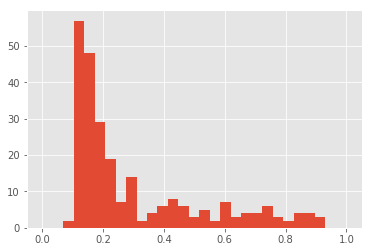

In [ ]:

plt.hist(scores,bins=np.linspace(0,1,30))

In [ ]:
label_df = pd.DataFrame({'topic_class':best_matches,'scores':scores})
label_df['label'] = label_df.topic_class.apply(get_dic_name)
label_df['top_words'] = top_words

In [ ]:
label_df[label_df.scores>0.3][['label','top_words','scores']]

,label,top_words,scores
7,Education,"børn,forældre,børnene,barn,voksne,børns,foræld...",0.455999
19,Education,"unge,unges,dag,danmark,__url__,år,derfor,går,s...",0.303912
23,EU,"eu,europa,europæiske,bruxelles,europæisk,storb...",0.854544
35,Economy,"skabe,skaber,udvikling,skabt,vilkår,udvikle,ba...",0.309407
48,Economy,"arbejdspladser,vækst,statslige,væksten,velstan...",0.717339
53,Taxes,"skat,skatteminister,karsten,skatteministeren,l...",0.871496
64,Immigration,"flygtninge,integration,asyl,integrationen,flug...",0.887721
71,Taxes,"betale,betaler,forvejen,fair,rimeligt,betalt,t...",0.361425
75,Education,"skole,elever,folkeskolen,skolen,lærere,elevern...",0.926097
79,Environment,"grønne,grøn,omstilling,miljø,bæredygtig,klima,...",0.913559


(array([0.000e+00, 2.100e+01, 1.583e+03, 6.032e+03, 8.917e+03, 8.800e+03,
        6.089e+03, 5.507e+03, 3.327e+03, 2.155e+03, 1.258e+03, 7.590e+02,
        5.470e+02, 3.230e+02, 3.030e+02, 1.360e+02, 1.050e+02, 7.400e+01,
        4.800e+01, 4.200e+01, 2.000e+01, 1.500e+01, 1.400e+01, 1.500e+01,
        8.000e+00, 4.000e+00, 1.100e+01, 1.100e+01, 1.000e+01, 9.000e+00,
        1.300e+01, 1.100e+01, 6.000e+00, 6.000e+00, 4.000e+00, 6.000e+00,
        5.000e+00, 3.000e+00, 2.000e+00, 5.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
        0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
        0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
        0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
        0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
        0.51020408, 0.53061224, 0.55102041, 0.5

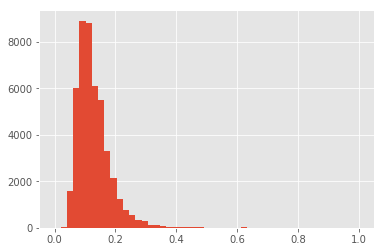

In [ ]:
plt.hist(Xt.max(axis=1),np.linspace(0,1,50))

In [ ]:
Xt.argsort()[:,-5:]

array([[ 17, 251,  32, 128, 192],
       [120, 148,  65,  79,  40],
       [103,   5,   4,  40, 162],
       ...,
       [ 47,  11, 121,   9,  78],
       [  5,  21, 232,  80,  32],
       [160,  32,   9,  29,  59]])

In [ ]:
#(topics.max(axis=1)==topics.sum(axis=1))

In [ ]:
#list(zip([get_dic_name(i) for i in best_matches],scores))
label_df[label_df.scores>0.4].groupby('label').scores.mean()

label
Crime              0.639685
Culture            0.488852
EU                 0.745399
Economy            0.586195
Education          0.626356
Elder care         0.635539
Employment         0.768166
Environment        0.630720
Foreign affairs    0.662989
Health             0.604615
Immigration        0.679010
Religion           0.624983
Science            0.822730
Social policy      0.423474
Taxes              0.647866
Name: scores, dtype: float64

In [ ]:
label_df[label_df.scores>0.4].groupby('label').scores.max()

label
Crime              0.929177
Culture            0.547194
EU                 0.854544
Economy            0.764250
Education          0.926097
Elder care         0.766193
Employment         0.850619
Environment        0.913559
Foreign affairs    0.802208
Health             0.895168
Immigration        0.887721
Religion           0.853733
Science            0.822730
Social policy      0.425743
Taxes              0.871496
Name: scores, dtype: float64

In [ ]:
# consider removing 'Social policy', 'Culture'

In [ ]:
#label_df.groupby('label').scores.max()

In [ ]:
#np.random.randint(1,10,size=(20,25)).dot(np.random.randint(1,10,size=(25,100))).shape

In [ ]:
import sys

In [ ]:
sys.version

'3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:09:58) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [ ]:
import graph_tool.draw 

In [ ]:
graph_tool.__version__

'2.26 (commit b89e6b4e, Thu Nov 9 14:55:43 2017 +0000)'

(array([ 70., 113.,  26.,  17.,  10.,   0.,   4.,   3.,   1.,   2.,   1.,
          2.,   0.,   0.,   0.,   1.,   1.,   0.,   1.]),
 array([0.        , 0.0018703 , 0.00374061, 0.00561091, 0.00748122,
        0.00935152, 0.01122183, 0.01309213, 0.01496243, 0.01683274,
        0.01870304, 0.02057335, 0.02244365, 0.02431396, 0.02618426,
        0.02805456, 0.02992487, 0.03179517, 0.03366548, 0.03553578]),
 <a list of 19 Patch objects>)

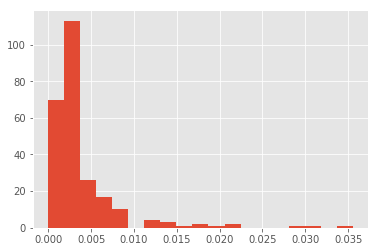

In [ ]:
sizes = Xt.sum(axis=0)/len(Xt)
plt.hist(sizes,bins=np.linspace(0,max(sizes),20))